In [328]:
from prometheus_api_client import *
import prometheus_api_client
from prometheus_api_client.utils import parse_datetime, parse_timedelta
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas as pd
# import seaborn as sns
# # Set default Seaborn style
# sns.set(style="darkgrid")
# sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

In [4]:
sample_df = pd.read_csv('sample_cluster_15d_15_min_int.csv',index_col='timestamp')

In [5]:
sample_df.head()

,Cpu_usage,Memory_usage(bytes),api_server_requests,api_server_requests_lt
timestamp,,,,
2022-05-24 06:10:09,10.851524,7.902974e+10,29,3.367296
2022-05-24 06:25:09,10.313238,7.976337e+10,37,3.610918
2022-05-24 06:40:09,10.851333,7.848636e+10,19,2.944439
2022-05-24 06:55:09,10.411907,8.006373e+10,30,3.401197
2022-05-24 07:10:09,10.873429,7.883173e+10,21,3.044522


In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()

In [10]:
scaler.fit(sample_df['Memory_usage(bytes)'].values.reshape(-1,1))

StandardScaler()

In [12]:
sample_df['Memory_usage(bytes)'] = scaler.transform(sample_df['Memory_usage(bytes)'].values.reshape(-1,1))

In [13]:
sample_df.head()

,Cpu_usage,Memory_usage(bytes),api_server_requests,api_server_requests_lt
timestamp,,,,
2022-05-24 06:10:09,10.851524,0.847365,29,3.367296
2022-05-24 06:25:09,10.313238,1.160429,37,3.610918
2022-05-24 06:40:09,10.851333,0.615487,19,2.944439
2022-05-24 06:55:09,10.411907,1.288604,30,3.401197
2022-05-24 07:10:09,10.873429,0.762870,21,3.044522


In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1],3)
    if p_value <= sig:
        print(f'{name} has p-value: {p_value}. It is stationary')
    else:
        print(f'{name} has p-value: {p_value}. It is non-stationary')

In [ ]:
for name, column in sample_df.iteritems():
    #print(name,column)
    adfuller_test(column,name=name)

Cpu_usage has p-value: 0.0. It is stationary
Memory_usage(bytes) has p-value: 0.0. It is stationary
api_server_requests_lt has p-value: 0.0. It is stationary


In [17]:
sample_df_differenced = sample_df.diff().dropna()

In [83]:
sample_df_differenced.shape

(1484, 4)

In [106]:
sample_df_differenced.drop(columns=['api_server_requests'],inplace=True)

In [22]:
import statsmodels.api as sm

In [26]:
sample_df.index

Index(['2022-05-24 06:10:09', '2022-05-24 06:25:09', '2022-05-24 06:40:09',
       '2022-05-24 06:55:09', '2022-05-24 07:10:09', '2022-05-24 07:25:09',
       '2022-05-24 07:40:09', '2022-05-24 07:55:09', '2022-05-24 08:10:09',
       '2022-05-24 08:25:09',
       ...
       '2022-06-08 14:55:09', '2022-06-08 15:10:09', '2022-06-08 15:25:09',
       '2022-06-08 15:40:09', '2022-06-08 15:55:09', '2022-06-08 16:10:09',
       '2022-06-08 16:25:09', '2022-06-08 16:40:09', '2022-06-08 16:55:09',
       '2022-06-08 17:10:09'],
      dtype='object', name='timestamp', length=1485)

In [107]:
length = len(sample_df_differenced)

In [148]:
split_ratio = 0.85
int(length*split_ratio)

1261

Performing Co Integration Test to check if there is statistical significance between the time series data

In [143]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [279]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(sample_df_differenced)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Cpu_usage ::  1362.13   > 24.2761   =>   True
Memory_usage(bytes) ::  807.71    > 12.3212   =>   True
api_server_requests_lt ::  306.55    > 4.1296    =>   True


In [154]:
df_train = sample_df_differenced[:int(length*split_ratio)]
df_test = sample_df_differenced[int(length*split_ratio):]

Trying VAR Model

In [110]:
from statsmodels.tsa.api import VAR

In [155]:
print(df_train.shape,df_test.shape)

(1261, 3) (223, 3)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


In [158]:
for i in range(1,10):
    model = VAR(df_train)
    result = model.fit(i)
    print(f'Lag Order = {i} AIC : {result.aic} BIC : {result.bic} FPE : {result.fpe} HQIC: {result.hqic}\n')

Lag Order = 1 AIC : -6.275183674925329 BIC : -6.226242084449657 FPE : 0.0018824453844847743 HQIC: -6.256792168634302

Lag Order = 2 AIC : -6.395303087936481 BIC : -6.309600519457585 FPE : 0.001669380391961887 HQIC: -6.363096098275596

Lag Order = 3 AIC : -6.514577875476119 BIC : -6.392067260915061 FPE : 0.0014816827099950456 HQIC: -6.4685366259164105

Lag Order = 4 AIC : -6.552834806590932 BIC : -6.393468979116771 FPE : 0.0014260703932228818 HQIC: -6.492940480130239

Lag Order = 5 AIC : -6.59726026394014 BIC : -6.400991957684288 FPE : 0.001364105837554179 HQIC: -6.52349400298415

Lag Order = 6 AIC : -6.623511825499913 BIC : -6.3902936752694295 FPE : 0.0013287656046195948 HQIC: -6.535854731742768

Lag Order = 7 AIC : -6.628769154955321 BIC : -6.3585536959451705 FPE : 0.001321803280066201 HQIC: -6.527202289259783

Lag Order = 8 AIC : -6.668528638221862 BIC : -6.361268305726088 FPE : 0.0012702865817129615 HQIC: -6.553033020499022

Lag Order = 9 AIC : -6.681243912542037 BIC : -6.3368910416

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Pyth

In [159]:
x = model.select_order(maxlags=12)

In [129]:
x.summary()

,AIC,BIC,FPE,HQIC
0,-5.120,-5.107,0.005978,-5.115
1,-6.265,-6.215,0.001903,-6.246
2,-6.384,-6.298,0.001689,-6.351
3,-6.503,-6.380,0.001499,-6.457
4,-6.542,-6.382,0.001442,-6.482
5,-6.587,-6.390*,0.001378,-6.513
6,-6.616,-6.382,0.001339,-6.528
7,-6.623,-6.351,0.001330,-6.521
8,-6.662,-6.354,0.001279,-6.546
9,-6.676,-6.331,0.001261,-6.547


In [215]:
model_fitted = model.fit(maxlags=4,ic='aic')
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Jun, 2022
Time:                     14:23:13
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.39347
Nobs:                     1257.00    HQIC:                  -6.49294
Log likelihood:          -1193.36    FPE:                 0.00142607
AIC:                     -6.55283    Det(Omega_mle):      0.00138272
--------------------------------------------------------------------
Results for equation Cpu_usage
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.007202         0.010484           -0.687           0.492
L1.Cpu_usage                     -0.545397         0.028720          -18.990           0.000
L1.Memor

In [165]:
from statsmodels.stats.stattools import durbin_watson

Checking the serial Correlation of the residuals

In [168]:
out = durbin_watson(model_fitted.resid)

In [216]:
model_fitted.k_ar

4

In [226]:
forecast_input = df_train.values

In [236]:
forecast_input.shape

(1261, 3)

In [227]:
output = model_fitted.forecast(y=forecast_input,steps=len(df_test))

In [228]:
output.shape

(223, 3)

In [229]:
df_forecast = pd.DataFrame(output,index=sample_df_differenced.index[int(length*split_ratio):],columns=sample_df_differenced.columns+'_1d')

In [230]:
df_forecast.shape

(223, 3)

In [231]:
df_test.shape

(223, 3)

These are one differenced values

In [282]:
print(sample_df_differenced.index[int(length*split_ratio):],df_test.index,df_forecast.index)

Index(['2022-06-06 09:40:09', '2022-06-06 09:55:09', '2022-06-06 10:10:09',
       '2022-06-06 10:25:09', '2022-06-06 10:40:09', '2022-06-06 10:55:09',
       '2022-06-06 11:10:09', '2022-06-06 11:25:09', '2022-06-06 11:40:09',
       '2022-06-06 11:55:09',
       ...
       '2022-06-08 14:55:09', '2022-06-08 15:10:09', '2022-06-08 15:25:09',
       '2022-06-08 15:40:09', '2022-06-08 15:55:09', '2022-06-08 16:10:09',
       '2022-06-08 16:25:09', '2022-06-08 16:40:09', '2022-06-08 16:55:09',
       '2022-06-08 17:10:09'],
      dtype='object', name='timestamp', length=223) Index(['2022-06-06 09:40:09', '2022-06-06 09:55:09', '2022-06-06 10:10:09',
       '2022-06-06 10:25:09', '2022-06-06 10:40:09', '2022-06-06 10:55:09',
       '2022-06-06 11:10:09', '2022-06-06 11:25:09', '2022-06-06 11:40:09',
       '2022-06-06 11:55:09',
       ...
       '2022-06-08 14:55:09', '2022-06-08 15:10:09', '2022-06-08 15:25:09',
       '2022-06-08 15:40:09', '2022-06-08 15:55:09', '2022-06-08 16:10:09',

In [296]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [233]:
df_results = invert_transformation(sample_df_differenced,df_forecast)

In [289]:
df_results

,Cpu_usage_1d,Memory_usage(bytes)_1d,api_server_requests_lt_1d,Cpu_usage_forecast,Memory_usage(bytes)_forecast,api_server_requests_lt_forecast
timestamp,,,,,,
2022-06-06 09:40:09,-0.107929,0.467387,-0.226753,-0.140881,-0.086433,-0.420909
2022-06-06 09:55:09,-0.014917,-0.289651,0.003100,-0.155798,-0.376084,-0.417809
2022-06-06 10:10:09,0.029891,0.193432,0.008253,-0.125907,-0.182652,-0.409556
2022-06-06 10:25:09,-0.025057,-0.136987,0.018931,-0.150964,-0.319639,-0.390625
2022-06-06 10:40:09,0.031602,0.099129,0.024248,-0.119362,-0.220510,-0.366377
...,...,...,...,...,...,...
2022-06-08 16:10:09,-0.003572,-0.001161,-0.000251,-0.905309,-0.512000,-0.443521
2022-06-08 16:25:09,-0.003572,-0.001161,-0.000251,-0.908881,-0.513161,-0.443772
2022-06-08 16:40:09,-0.003572,-0.001161,-0.000251,-0.912452,-0.514322,-0.444023


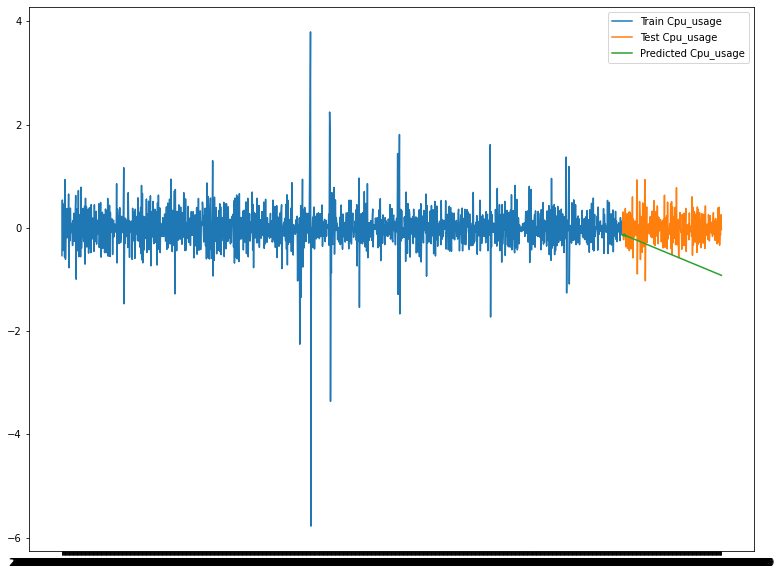

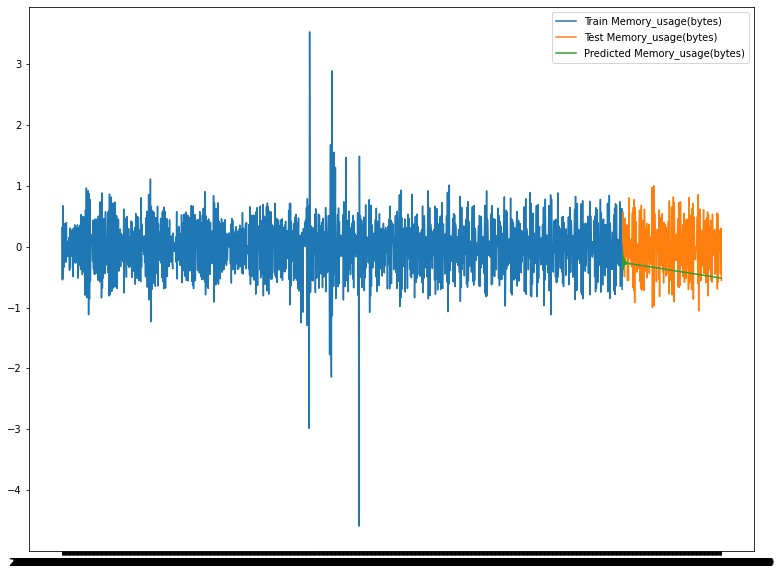

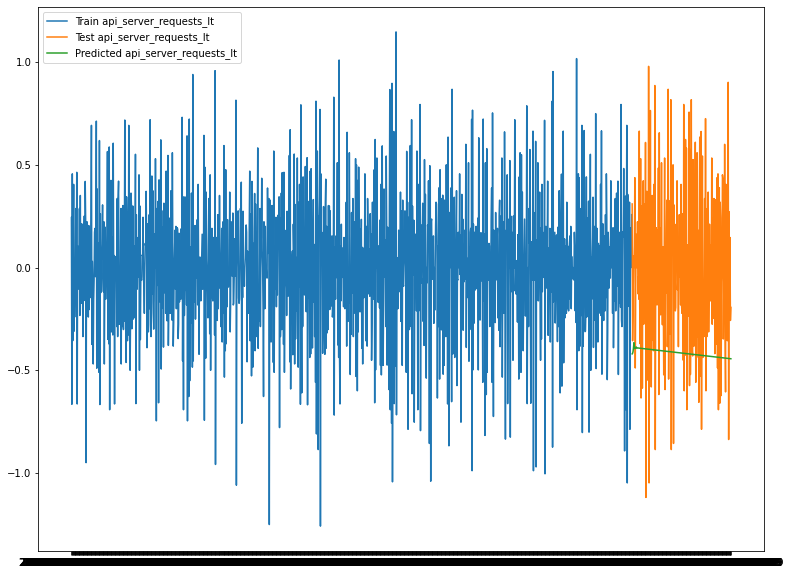

In [281]:
for col in ['Cpu_usage', 'Memory_usage(bytes)','api_server_requests_lt' ]:
    #plt.rcParams["figure.figsize"] = [6,5]
    plt.plot( df_train[str(col)], label='Train '+ col)
    plt.plot(df_test[str(col)], label='Test '+ col)
    plt.plot(df_results[str(col)+'_forecast'], label='Predicted '+str(col))
    plt.legend(loc='best')
    plt.show()

In [225]:
def mean_absolute_percentage_error(y_actual, y_pred):
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    return np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

In [242]:
from sklearn import metrics
def evaluation_metrics(y_actual, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_actual, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_actual, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_actual, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_actual, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_actual, y_pred)}',end='\n\n')

In [243]:
for col in ['Cpu_usage', 'Memory_usage(bytes)','api_server_requests_lt' ]:
    print(f"The Metrics for the column {col}")
    evaluation_metrics(df_test[str(col)],df_results[str(col+'_forecast')])

The Metrics for the column Cpu_usage
Evaluation metric results:-
MSE is : 0.4117320704816474
MAE is : 0.554502814061681
RMSE is : 0.6416635181165027
MAPE is : 1006.9482127879778
R2 is : -3.887093982828411

The Metrics for the column Memory_usage(bytes)
Evaluation metric results:-
MSE is : 0.37649202636235357
MAE is : 0.5109018484073113
RMSE is : 0.6135894607653831
MAPE is : 430.98490519568804
R2 is : -0.7070845738108473

The Metrics for the column api_server_requests_lt
Evaluation metric results:-
MSE is : 0.34300600420225136
MAE is : 0.4810699546318811
RMSE is : 0.5856671445473541
MAPE is : inf
R2 is : -1.0095216287607975



Trying VARMA Model

In [149]:
from pmdarima import auto_arima

In [254]:
parameters = []
for col, column in df_train.iteritems():
    print(f"Searching order for p and q for: {col}")
    stepwise_model = auto_arima(df_train[str(col)],start_p=1,start_q=1,max_p=7,max_q=7,trace=True,maxiter=1000)
    optimal_order = stepwise_model.get_params().get('order')
    print(f"The Optimal Order value for the column {col} is {optimal_order}")
    if optimal_order[0] == 0 and optimal_order[-1] == 0:
        continue
    else:
        parameters.append(optimal_order)

Searching order for p and q for: Cpu_usage
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1129.485, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1465.601, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1222.752, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1128.943, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1463.690, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1129.671, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1127.553, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1128.145, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1128.322, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1220.958, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 2.442 seconds
The Optimal Order value for the column Cpu_usage is (0,

In [256]:
stepwise_model.get_params()

{'maxiter': 1000,
 'method': 'lbfgs',
 'order': (2, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [255]:
parameters

[(0, 0, 1), (2, 0, 4), (2, 0, 1)]

In [257]:
from timeit import default_timer as timer

In [258]:
timer()

128280.884881129

,Cpu_usage,Memory_usage(bytes),api_server_requests_lt
timestamp,,,
2022-05-24 06:25:09,-0.538286,0.313064,0.243622
2022-05-24 06:40:09,0.538095,-0.544942,-0.666479
2022-05-24 06:55:09,-0.439426,0.673117,0.456758
2022-05-24 07:10:09,0.461522,-0.525734,-0.356675
2022-05-24 07:25:09,-0.194476,0.297109,-0.048790
...,...,...,...
2022-06-08 16:10:09,-0.336190,0.029082,0.271934
2022-06-08 16:25:09,-0.067714,0.247224,-0.100083
2022-06-08 16:40:09,-0.141619,-0.441933,0.146603


In [286]:
results_df = pd.DataFrame(columns=['p','q','RMSE_Cpu_usage','RMSE_Memory_usage(bytes)','RMSE_api_server_requests_lt'])

In [301]:
from statsmodels.tsa.statespace.varmax import VARMAX

for param in parameters:
    model = VARMAX(df_train,order=(param[0],param[2])).fit(disp=False)
    df_forecast = model.forecast(steps=len(df_test))
    df_results = invert_transformation(sample_df_differenced, df_forecast)
    cpu_rmse = np.sqrt(metrics.mean_squared_error(df_test['Cpu_usage'],df_results['Cpu_usage'+'_forecast']))
    memory_rmse = np.sqrt(metrics.mean_squared_error(df_test['Memory_usage(bytes)'],df_results['Memory_usage(bytes)'+'_forecast']))    
    api_server_rmse = np.sqrt(metrics.mean_squared_error(df_test['api_server_requests_lt'],df_results['api_server_requests_lt'+'_forecast']))
    row = {'p':param[0],'q':param[2],'RMSE_Cpu_usage':cpu_rmse,'RMSE_Memory_usage(bytes)':memory_rmse,'RMSE_api_server_requests_lt':api_server_rmse}
    results_df = results_df.append(row,ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

In [303]:
results_df.columns

Index(['p', 'q', 'RMSE_Cpu_usage', 'RMSE_Memory_usage(bytes)',
       'RMSE_api_server_requests_lt'],
      dtype='object')

In [284]:
sample_df_differenced.columns

Index(['Cpu_usage', 'Memory_usage(bytes)', 'api_server_requests_lt'], dtype='object')

In [305]:
results_df.sort_values(by = ['RMSE_Cpu_usage', 'RMSE_Memory_usage(bytes)',
       'RMSE_api_server_requests_lt'])

,p,q,RMSE_Cpu_usage,RMSE_Memory_usage(bytes),RMSE_api_server_requests_lt
3,2.0,1.0,0.562587,0.583833,0.470217
2,2.0,4.0,0.648636,0.575849,0.459331
0,0.0,1.0,0.729398,0.638652,0.493985
1,0.0,1.0,0.729398,0.638652,0.493985


In [307]:
model = VARMAX(df_train,order=(2,1)).fit(disp=False)
df_forecast = model.forecast(steps=len(df_test))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [330]:
df_forecast

,Cpu_usage,Memory_usage(bytes),api_server_requests_lt
2022-06-06 09:40:09,-0.050290,0.478942,-0.044994
2022-06-06 09:55:09,0.030456,-0.283868,0.024242
2022-06-06 10:10:09,-0.032448,0.178144,-0.010932
2022-06-06 10:25:09,0.011433,-0.109702,0.005867
2022-06-06 10:40:09,-0.014631,0.066609,-0.003336
...,...,...,...
2022-06-08 16:10:09,-0.003254,-0.000869,-0.000042
2022-06-08 16:25:09,-0.003254,-0.000869,-0.000042
2022-06-08 16:40:09,-0.003254,-0.000869,-0.000042
2022-06-08 16:55:09,-0.003254,-0.000869,-0.000042


In [308]:
results = invert_transformation(sample_df_differenced,df_forecast)

In [321]:
results.columns

Index(['Cpu_usage', 'Memory_usage(bytes)', 'api_server_requests_lt',
       'Cpu_usage_forecast', 'Memory_usage(bytes)_forecast',
       'api_server_requests_lt_forecast'],
      dtype='object')

In [310]:
for col in ['Cpu_usage', 'Memory_usage(bytes)','api_server_requests_lt' ]:
    print(f"The Metrics for the column {col}")
    evaluation_metrics(df_test[str(col)],results[str(col+'_forecast')])

The Metrics for the column Cpu_usage
Evaluation metric results:-
MSE is : 0.31650422459039906
MAE is : 0.47417381579402135
RMSE is : 0.562587081784144
MAPE is : 829.5202815249685
R2 is : -2.756777774745769

The Metrics for the column Memory_usage(bytes)
Evaluation metric results:-
MSE is : 0.3408605785907998
MAE is : 0.4883021413488062
RMSE is : 0.5838326631756738
MAPE is : 384.04851796746397
R2 is : -0.5455249906742192

The Metrics for the column api_server_requests_lt
Evaluation metric results:-
MSE is : 0.22110372785886337
MAE is : 0.3764936906089231
RMSE is : 0.47021668181686554
MAPE is : inf
R2 is : -0.29534969618211426



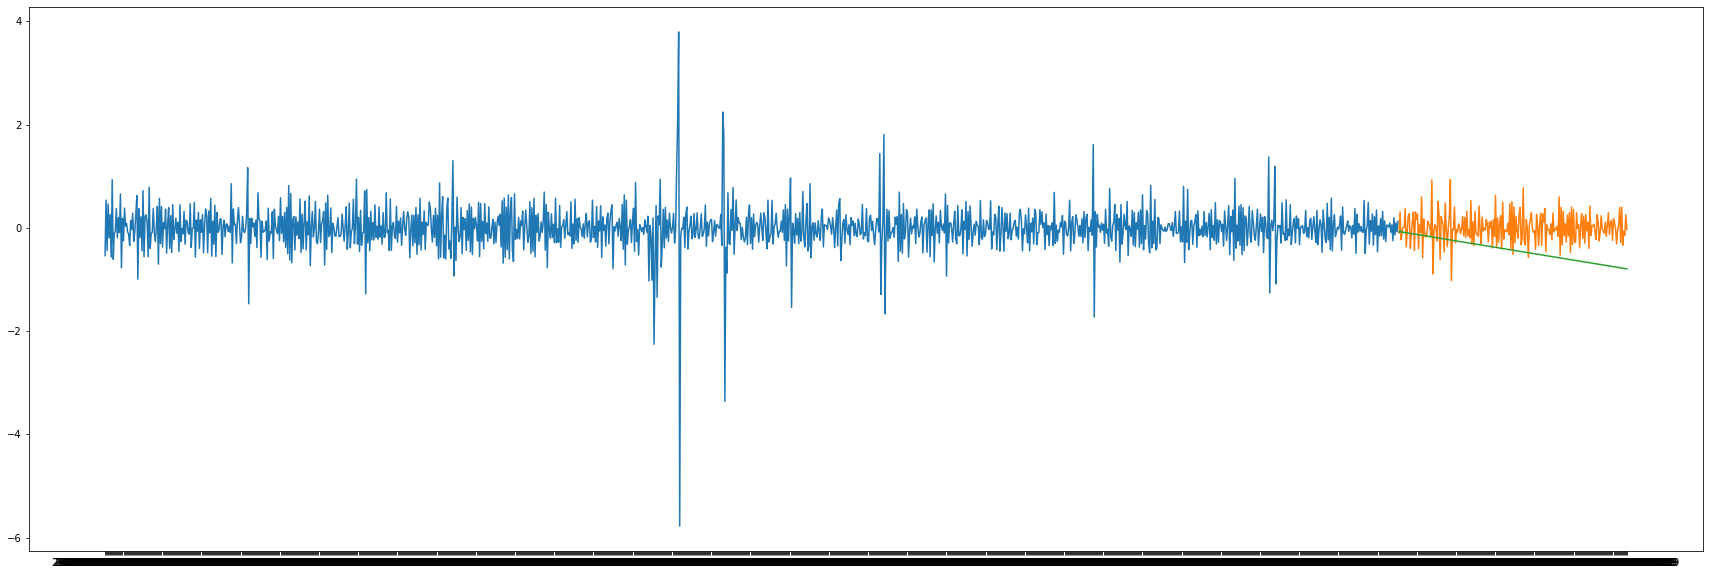

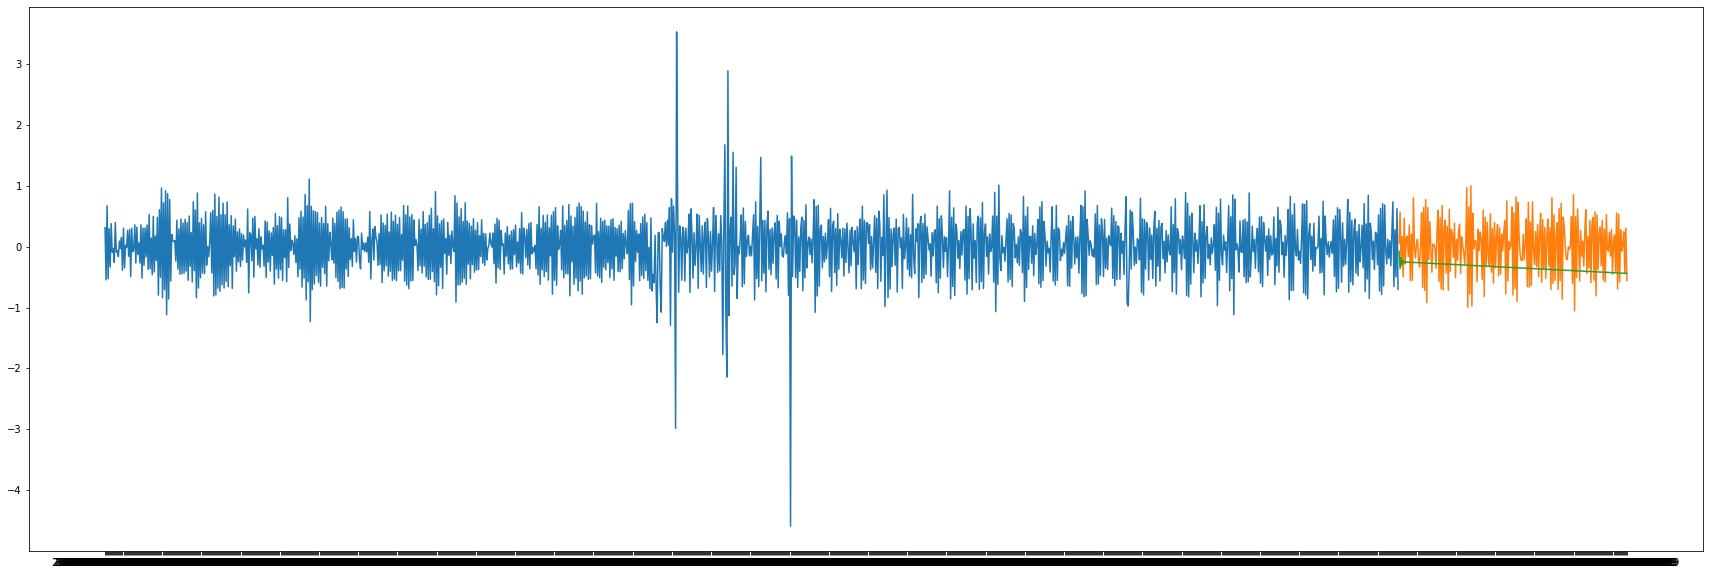

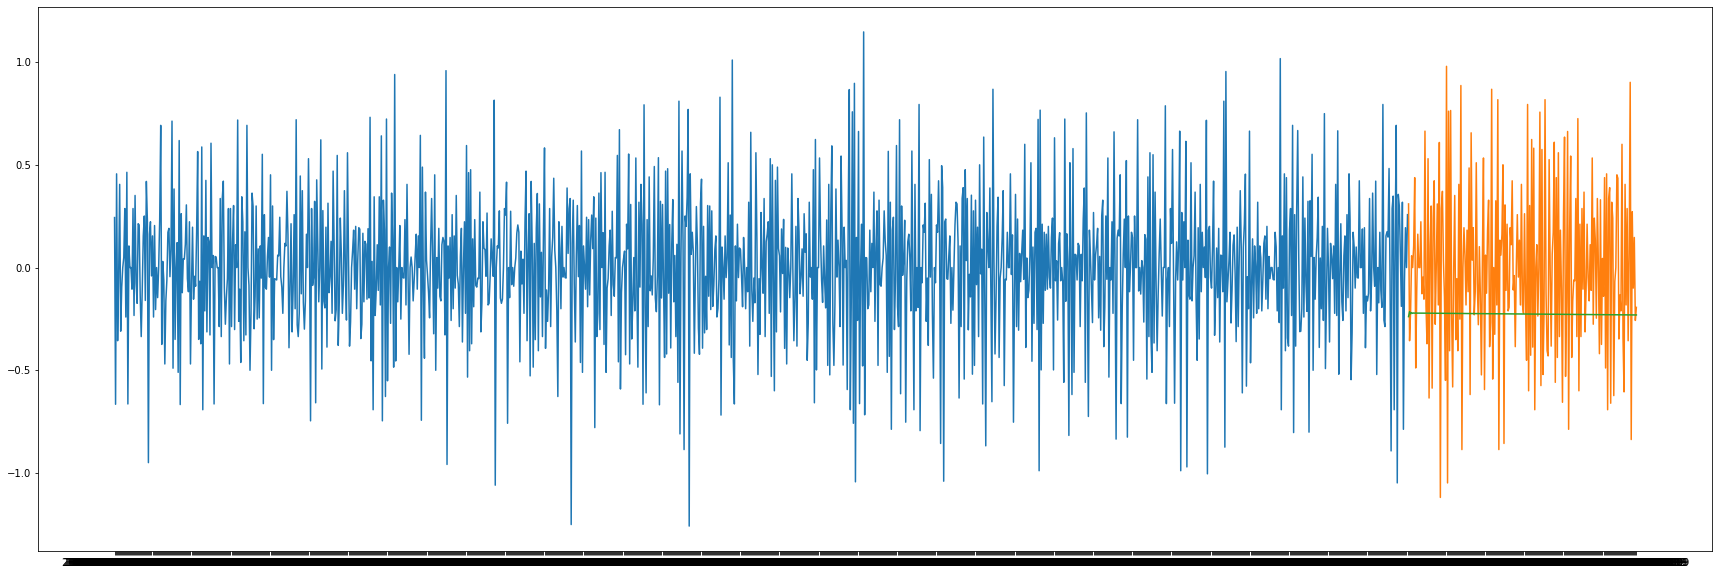

In [336]:
for col in ['Cpu_usage', 'Memory_usage(bytes)','api_server_requests_lt' ]:
    #plt.rcParams["figure.figsize"] = [6,5]
    plt.plot( df_train[str(col)], label='Train '+ col)
    plt.plot(df_test.index,df_test[str(col)], label='Test '+ col)
    plt.plot(df_test.index,df_results[str(col+'_forecast')],label='predicted'+ col)
    #plt.legend(loc='best')
    plt.show()